In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
path = "/content/drive/MyDrive/Cat_N_Dog_Dataset.zip"

!unzip -q "{path}"
!ls

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
input_path = []
label = []

test_dir = "test_set/test_set/"

for class_name in os.listdir(test_dir):
    for path in os.listdir(test_dir+class_name):
        if path.endswith('.jpg'):
            if class_name == 'cats':
                label.append(0)
            else:
                label.append(1)
            input_path.append(os.path.join(test_dir, class_name, path))

print(input_path[0], label[0])


In [9]:
df_test = pd.DataFrame()
df_test['images'] = input_path
df_test['label'] = label
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head()

,images,label
0,training_set/training_set/cats\cat.1927.jpg,0
1,training_set/training_set/dogs\dog.3037.jpg,1
2,training_set/training_set/cats\cat.3293.jpg,0
3,training_set/training_set/cats\cat.2206.jpg,0
4,training_set/training_set/cats\cat.3613.jpg,0


In [6]:
input_path = []
label = []

train_dir = "training_set/training_set/"

for class_name in os.listdir(train_dir):
    for path in os.listdir(train_dir+class_name):
        if path.endswith('.jpg'):
            if class_name == 'cats':
                label.append(0)
            else:
                label.append(1)
            input_path.append(os.path.join(train_dir, class_name, path))

print(input_path[0], label[0])

training_set/training_set/cats\cat.1.jpg 0


In [7]:
df_train = pd.DataFrame()
df_train['images'] = input_path
df_train['label'] = label
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,images,label
0,training_set/training_set/dogs\dog.441.jpg,1
1,training_set/training_set/dogs\dog.1268.jpg,1
2,training_set/training_set/cats\cat.2660.jpg,0
3,training_set/training_set/dogs\dog.1494.jpg,1
4,training_set/training_set/cats\cat.1863.jpg,0


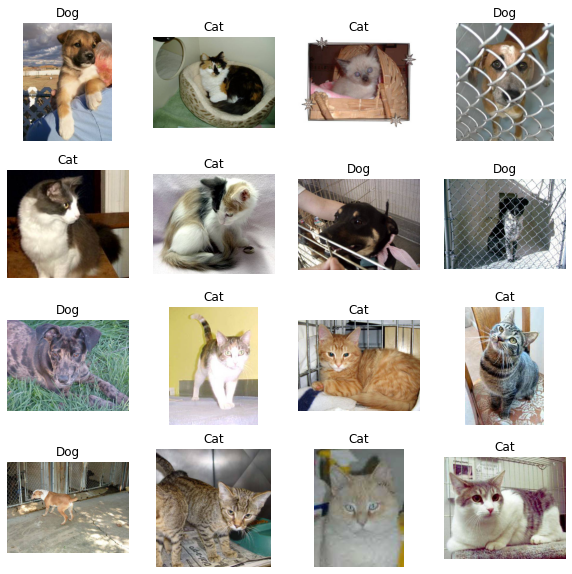

In [ ]:
plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4, i+1)
    img = mpimg.imread(df_train['images'][i])
    if df_train.loc[i, 'label'] == 0:
        plt.title('Cat')
    else:
        plt.title('Dog')
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [10]:
df_train['label'] = df_train['label'].astype('str')
df_test['label'] = df_test['label'].astype('str')
train, val = train_test_split(df_train, test_size=0.2, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    rescale = 1./255,  
    rotation_range = 40, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    val, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 6404 validated image filenames belonging to 2 classes.
Found 1601 validated image filenames belonging to 2 classes.


In [12]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [13]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
 4/13 [========>.....................] - ETA: 1:54 - loss: 0.9774 - accuracy: 0.5098

<Figure size 432x288 with 0 Axes>

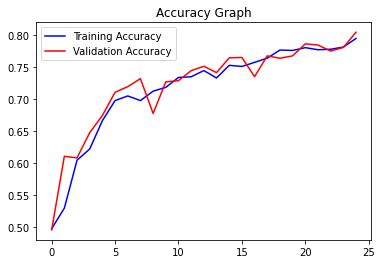

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

Found 2023 validated image filenames belonging to 2 classes.
4/4 [==============================] - 13s 3s/step


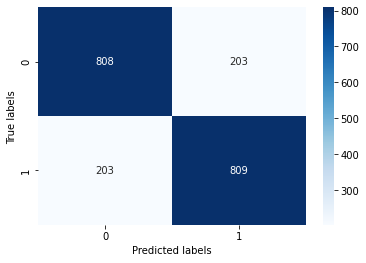

In [ ]:
test_generator = val_generator.flow_from_dataframe(
    df_test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary',
    shuffle=False
)

y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

df_test['label'] =df_test['label'].astype(int)

cm = confusion_matrix(df_test['label'], y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
print('Precision score:', precision_score(df_test['label'], y_pred))
print('Recall score:', recall_score(df_test['label'], y_pred))
print('F1 score:', f1_score(df_test['label'], y_pred))
print('Accuracy score:', accuracy_score(df_test['label'], y_pred))

Precision score: 0.799407114624506
Recall score: 0.799407114624506
F1 score: 0.799407114624506
Accuracy score: 0.7993079584775087


In [ ]:
cat_indices = test_generator.class_indices['0']
cat_mask = (df_test['label'] == cat_indices)
cat_accuracy = accuracy_score(df_test['label'][cat_mask], y_pred[cat_mask])
print("Accuracy for Cat:", cat_accuracy)

dog_indices = test_generator.class_indices['1']
dog_mask = (df_test['label']== dog_indices)
dog_accuracy = accuracy_score(df_test['label'][dog_mask], y_pred[dog_mask])
print("Accuracy for Dog :", dog_accuracy)

Accuracy for Cat: 0.7992087042532147
Accuracy for Dog : 0.799407114624506


In [ ]:
#generate a code for a 1+2



16/16 [==============================] - 0s 7ms/step


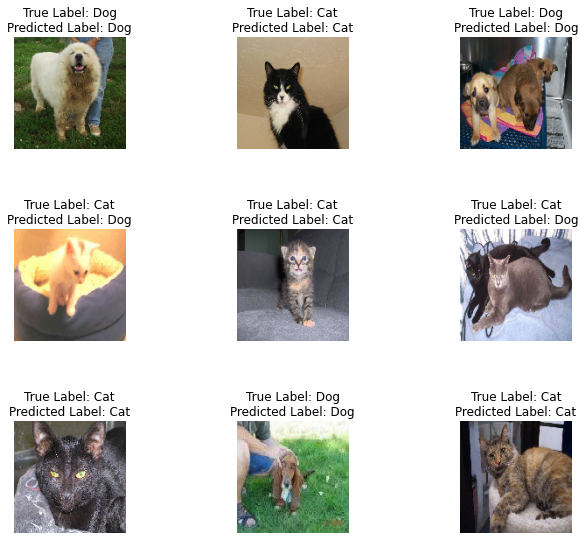

In [ ]:
test_images, test_labels = next(test_generator)
pred_labels = model.predict(test_images)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
axes = axes.ravel()

for i in np.arange(0, 9):
    axes[i].imshow(test_images[i])
    if test_labels[i] == 0:
        true_label = "Cat"
    else:
        true_label = "Dog"
    if pred_labels[i] <= 0.5:
        pred_label = "Cat"
    else:
        pred_label = "Dog"
    axes[i].set_title("True Label: {}\nPredicted Label: {}".format(true_label, pred_label))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)  
plt.show()

1/1 [==============================] - 0s 33ms/step


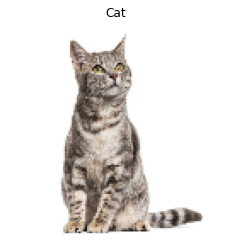

In [ ]:
image_path = "/content/cat.jpg"
img = load_img(image_path, target_size=(128, 128))
img = img_to_array(img) / 255.0
img = img.reshape(1, 128, 128, 3)

pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'

plt.imshow(img.squeeze())
plt.title(label)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step


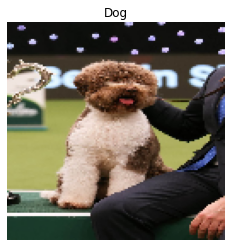

In [ ]:
image_path = "/content/dog.jpg"
img = load_img(image_path, target_size=(128, 128))
img = img_to_array(img) / 255.0
img = img.reshape(1, 128, 128, 3)

pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'

plt.imshow(img.squeeze())
plt.title(label)
plt.axis('off')
plt.show()